# View simulated bunch 

In [1]:
import sys
import os
from os.path import join
from tqdm.notebook import tqdm
from tqdm.notebook import trange
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import proplot as pplt
from ipywidgets import widgets
from ipywidgets import interactive

sys.path.append('/Users/46h/Research/code/btf-data-analysis/')
from tools import plotting as mplt
from tools import utils

pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'viridis'
pplt.rc['pdf.fonttype'] = 42

## Load data 

In [2]:
folder = '/Users/46h/Dropbox (ORNL)/projects/btf/simulations/2022-07-01-benchmark_29mA/run2/data/'
os.listdir(folder)

['220726181156-longemittance-emittance-z-dE.csv',
 '.DS_Store',
 'z-input.png',
 'run_MEBT123_HZ04_VT34a_hist_2.txt',
 'compare_longemit_csv.html',
 'emittance-data-x-220701191915.csv',
 '2Dx3_220701_HZ04_29mA_10M.dat',
 'x-input.png',
 'emittance-data-y-220701191040.csv',
 'run_MEBT123_HZ04_VT34a_bunch_2.txt',
 'y-input.png']

In [3]:
bunch_filename = 'run_MEBT123_HZ04_VT34a_bunch_2.txt'
hist_filename = 'run_MEBT123_HZ04_VT34a_hist_2.txt'

In [4]:
def load_bunch(filename, dframe=False):
    df = pd.read_table(filename, sep=' ', skiprows=14, usecols=range(0, 6), 
                       names=['x', 'xp', 'y', 'yp', 'z', 'dE'])
    if dframe:
        return df
    return df.values

def read_history(filename):
    file = open(filename, 'r')
    names = file.readlines()[0].split(',')
    names = [name.lstrip().split('[')[0].rstrip() for name in names]
    file.close()
    df = pd.read_table(filename, sep=' ', skiprows=1, names=names, usecols=range(len(names)))
    return df

In [5]:
X = load_bunch(join(folder, bunch_filename))
X = X * 1000.0  # mm, mrad, mm, mrad, mm, MeV
X5d = X[:, [0, 1, 2, 3, 5]]  # x, x', y, y', energy

Set up grid.

In [6]:
# Load 5D grid coordinates from measurement. These should be centered on the 
# beam centroid.
coords = utils.load_stacked_arrays('data/bunch/coords_220625182720-scan-xxpy-image-ypdE_cropped.npz')
X5d = X5d - np.mean(X5d, axis=0)

# New bin edges with different resolution.
# n_bins = 'same'
n_bins = [95, 95, 60, 60, len(coords[4])]
edges = []
for i, c in enumerate(coords):
    delta = 0.5 * np.diff(c)[0]
    n = len(c) if n_bins == 'same' else n_bins[i]
    edges.append(np.linspace(c[0] - delta, c[-1] + delta, n + 1))
    
if n_bins != 'same':
    coords = [0.5 * (e[:-1] + e[1:]) for e in edges]

In [7]:
shape = [len(c) for c in coords]
print(shape)

[95, 95, 60, 60, 60]


## 2D projections 

In [8]:
frac_thresh = 10.0**-3.0
dims = ["x", "x'", "y", "y'", "w"]
units = ["mm", "mrad", "mm", "mrad", "MeV"]
labels = [f'{d} [{u}]' for d, u in zip(dims, units)]
prof_kws = dict(lw=0.5, alpha=0.7, color='white', scale=0.12, kind='step')

In [ ]:
def update(cmap, dim1, dim2, log):
    if dim1 == dim2:
        return
    i = dims.index(dim1)
    j = dims.index(dim2)
    fig, ax = pplt.subplots()
    H, _ = np.histogramdd(
        X[:, [i, j]], 
        bins=[edges[i], edges[j]],
    )
    mplt.plot_image(
        H / np.max(H), 
        x=coords[i], y=coords[j], 
        ax=ax, 
        colorbar=True, 
        norm='log' if log else None, 
        profx=True,
        profy=True,
        handle_log='floor',
#         frac_thresh=0.9e-3,
        prof_kws=prof_kws,
        discrete=False,
        cmap=cmap,
        contour=True,
        contour_kws=dict(color='white', levels=[0.1, 0.9]),
    )
    ax.format(xlabel=labels[i], ylabel=labels[j])
    plt.show()

interactive(update, cmap=['viridis', 'dusk_r', 'mono_r'], dim1=dims, dim2=dims, log=False)

## Slices

In [9]:
f, _ = np.histogramdd(X5d, edges)

In [10]:
f = f / np.max(f)

In [11]:
# f[f < 0.001] = 0

### Max pixel in 5D array

In [ ]:
ind = np.unravel_index(np.argmax(f), f.shape)
ind = tuple([i for i in ind])
print('max pixel indices:', ind)

In [ ]:
prof = True
axes_slice = [(k, j, i) for i in range(f.ndim) for j in range(i) for k in range(j)]
axes_view = [tuple([i for i in range(f.ndim) if i not in axis])
             for axis in axes_slice]
for axis, axis_view in tqdm(zip(axes_slice, axes_view)):
    idx = utils.make_slice(5, axis, [ind[i] for i in axis])
    f_slice = f[idx]
    f_slice = f_slice / np.max(f_slice)
    
    dim1, dim2 = [dims[i] for i in axis_view]
    
    fig, plot_axes = pplt.subplots(ncols=2)
    for ax, norm in zip(plot_axes, [None, 'log']):
        mplt.plot_image(f_slice, x=coords[axis_view[0]], y=coords[axis_view[1]],
                        ax=ax,
                        profx=prof, profy=prof, prof_kws=prof_kws, handle_log='floor',
                        linewidth=0, rasterized=True, ec='None',
                        frac_thresh=frac_thresh, norm=norm, colorbar=True)
    plot_axes.format(xlabel=dim1, ylabel=dim2)
    string = 'figures/int_slice_'
    for i in axis:
        string += f'{dims[i]}-{ind[i]}'
    _dims = [dims[i] for i in axis]
    _units = [units[i] for i in axis]
    _vals = [coords[i][ind[i]] for i in axis]
    plot_axes.format(suptitle=f'{_dims[0]} = {_vals[0]:.2f} [{_units[0]}],  {_dims[1]} = {_vals[1]:.2f} [{_units[1]}],  {_dims[2]} = {_vals[2]:.2f} [{_units[2]}]')
    plot_axes.format(suptitle_kw=dict(fontweight='normal'))
    plt.savefig(string)
    plt.show()

### Energy slices

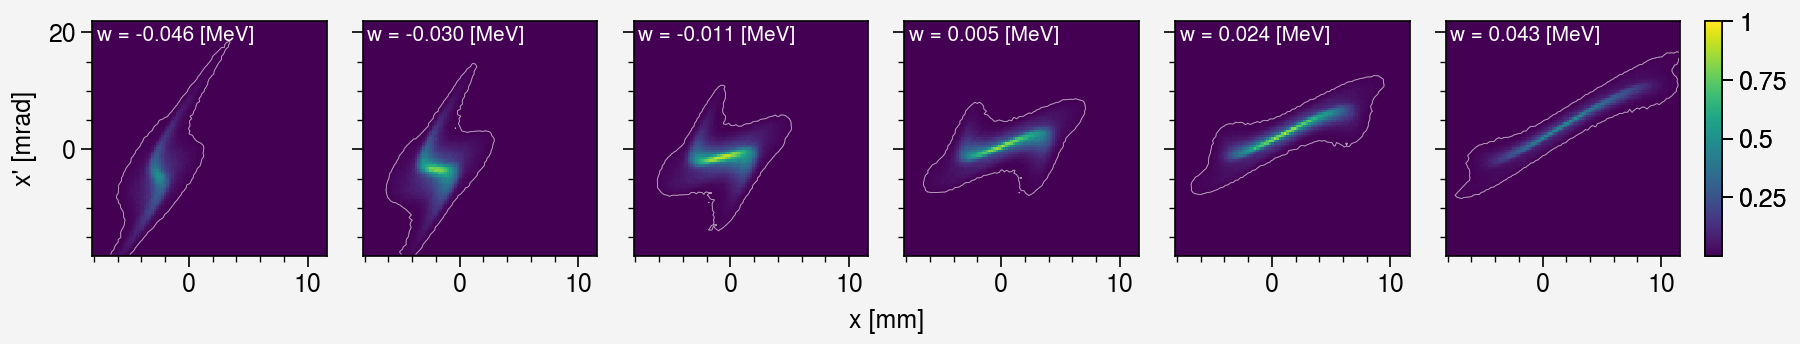

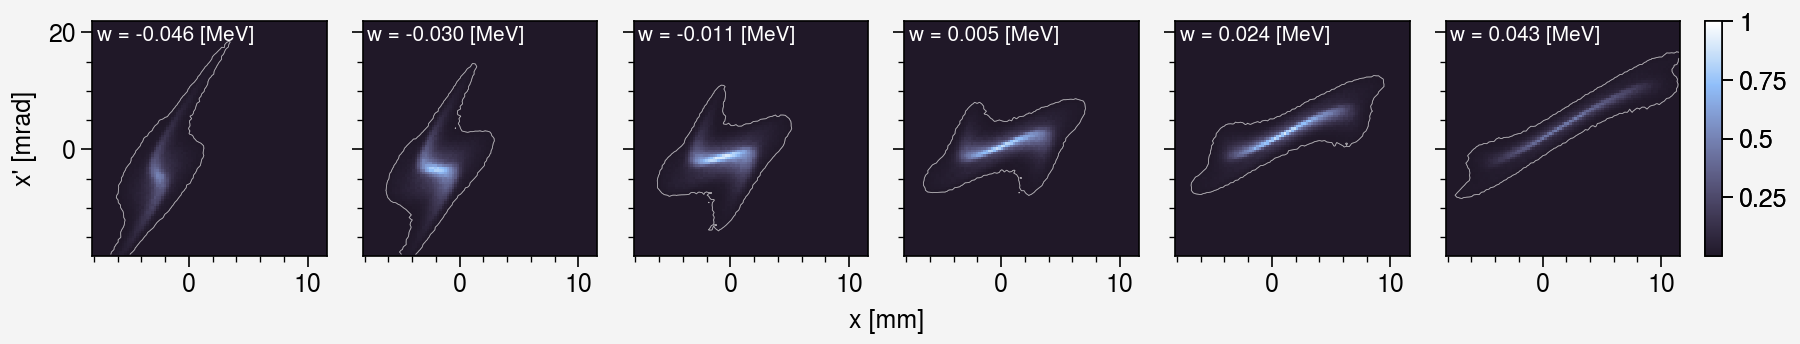

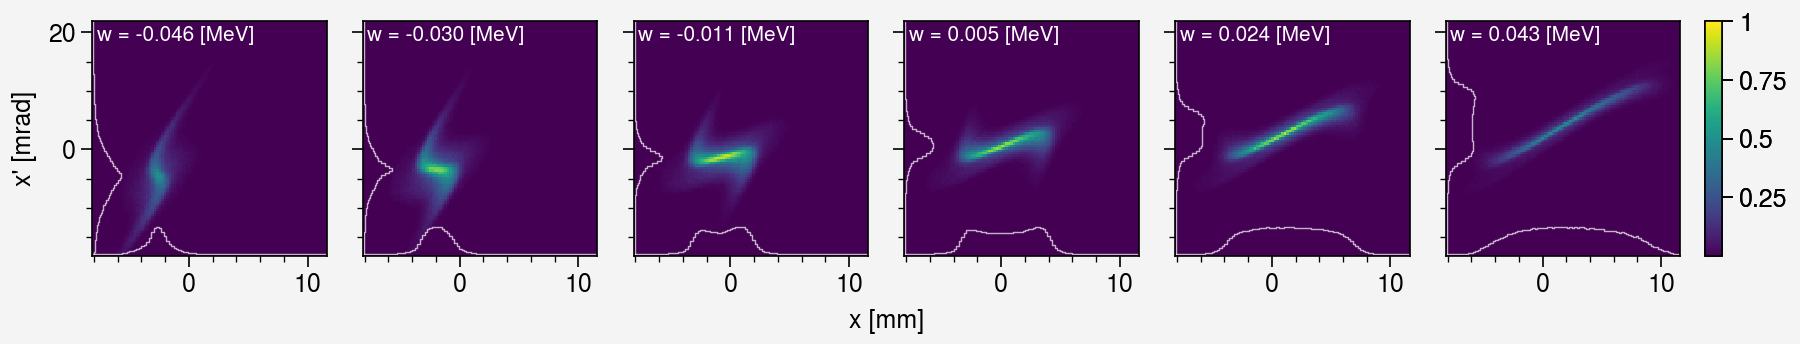

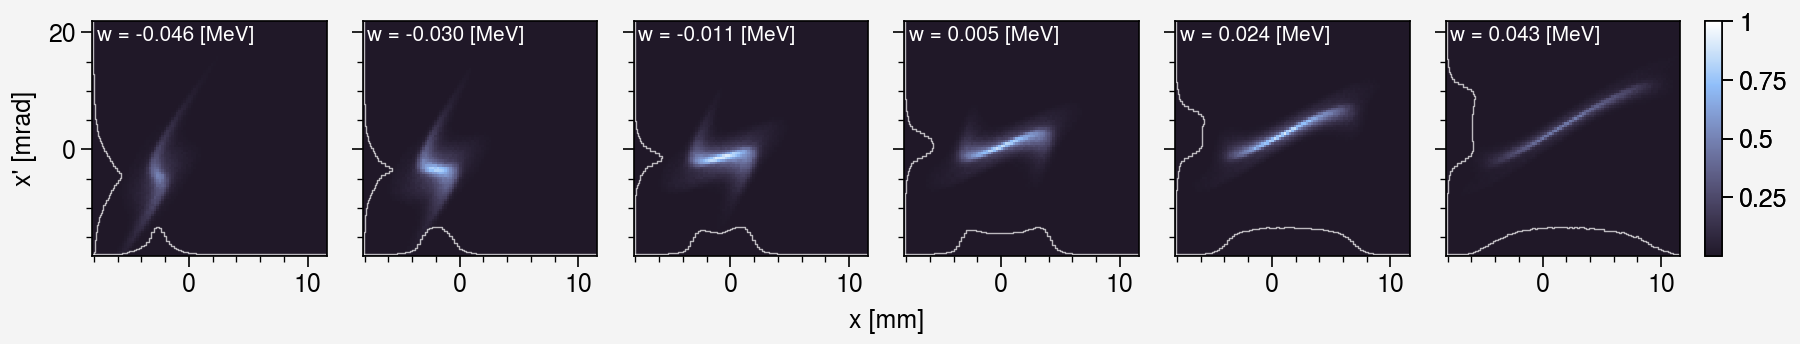

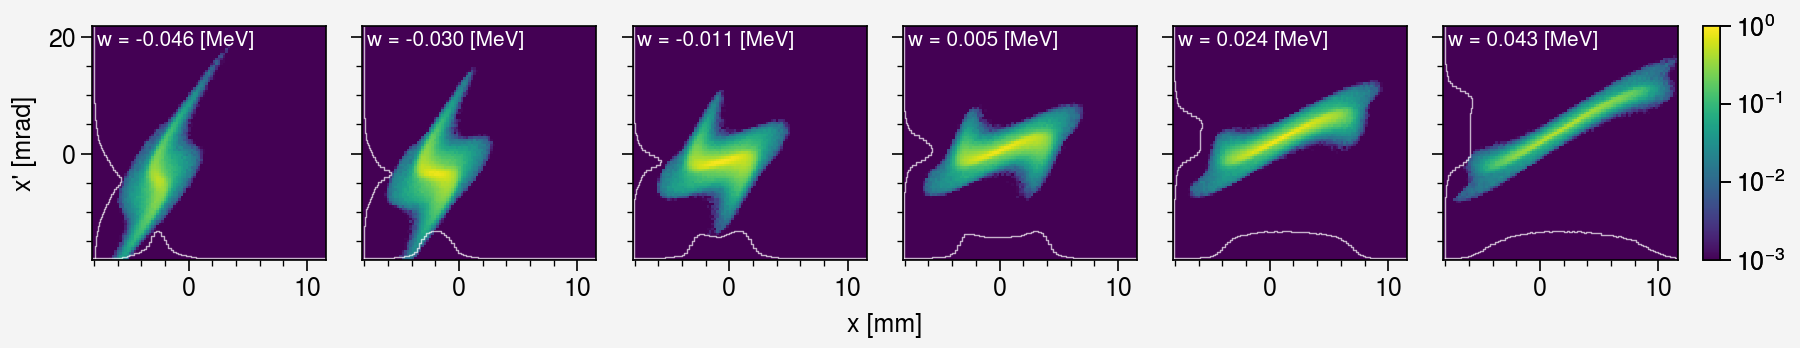

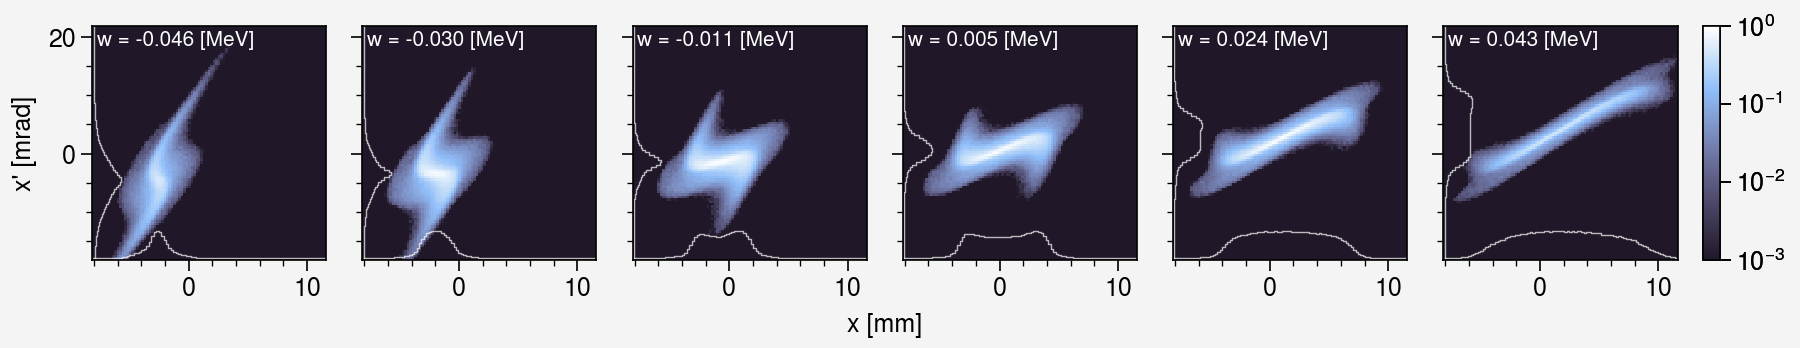

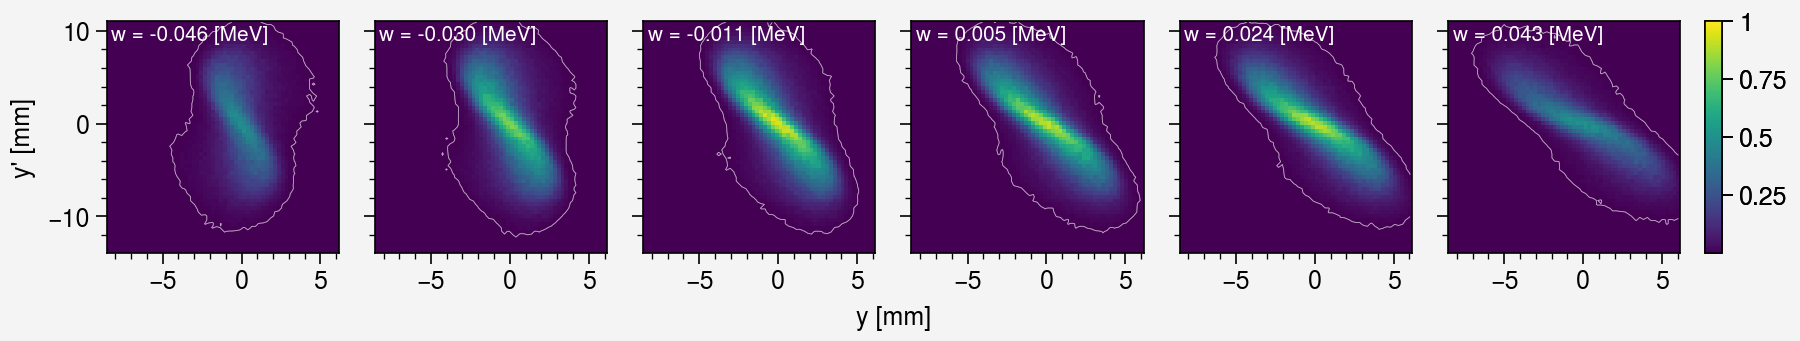

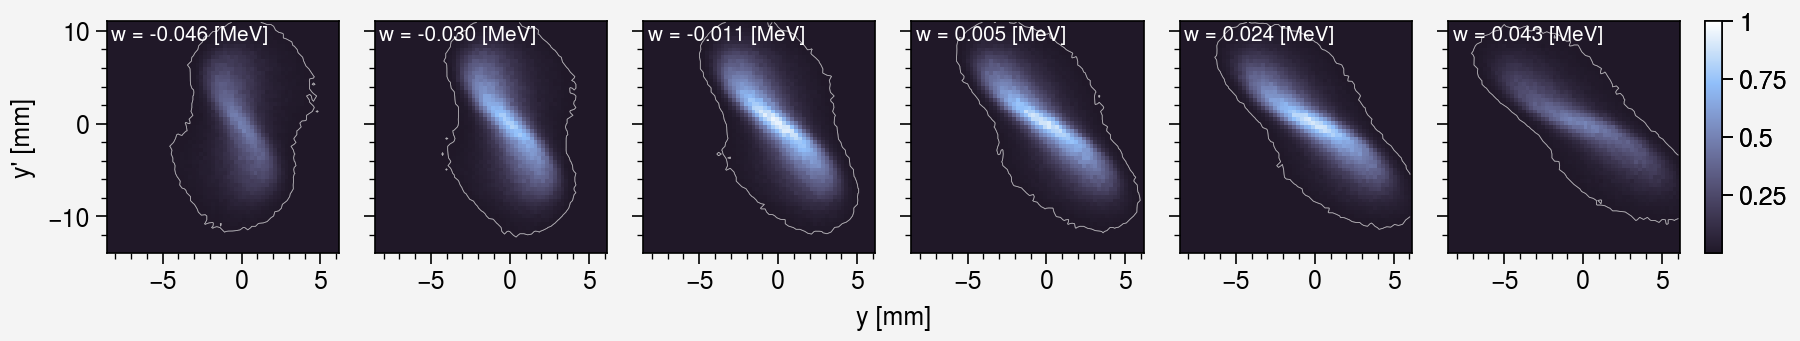

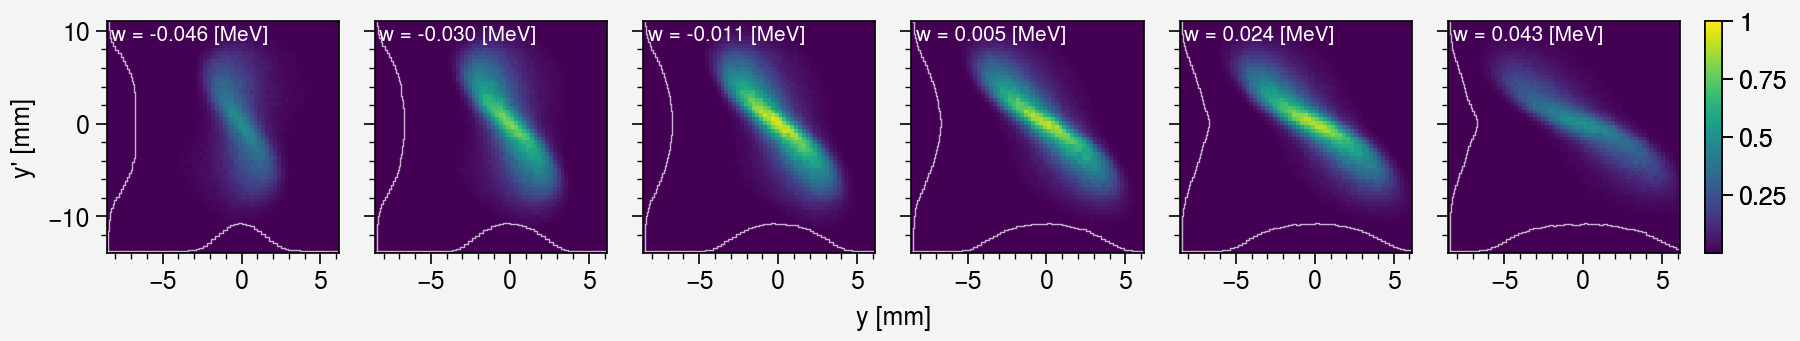

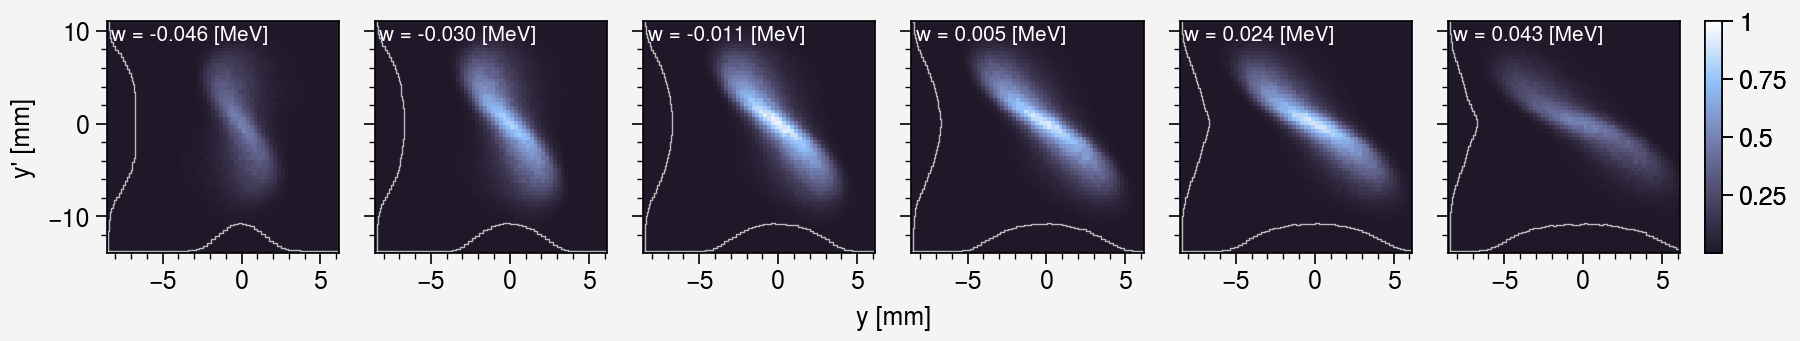

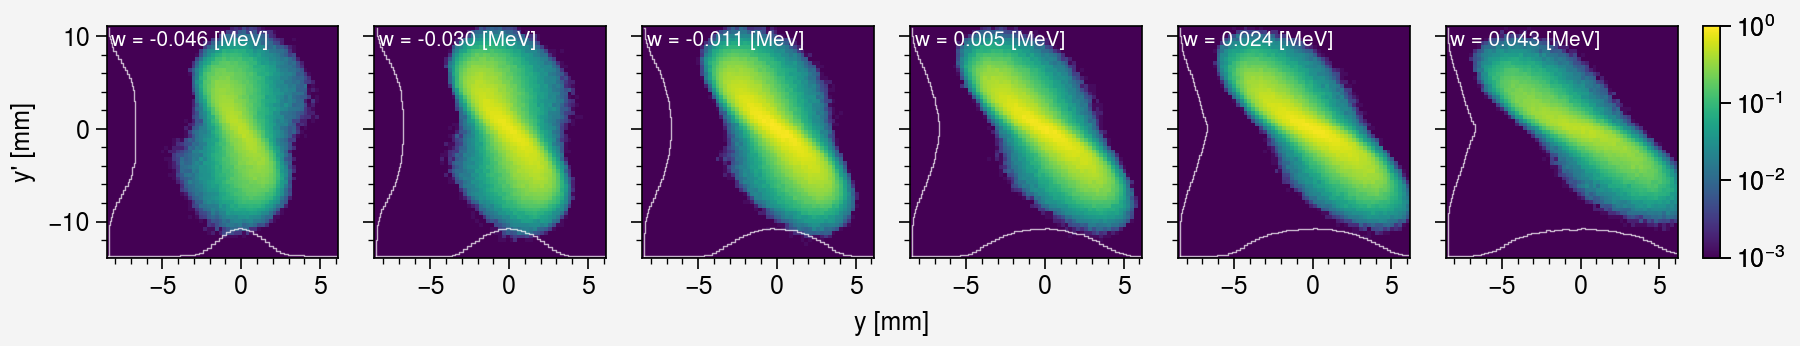

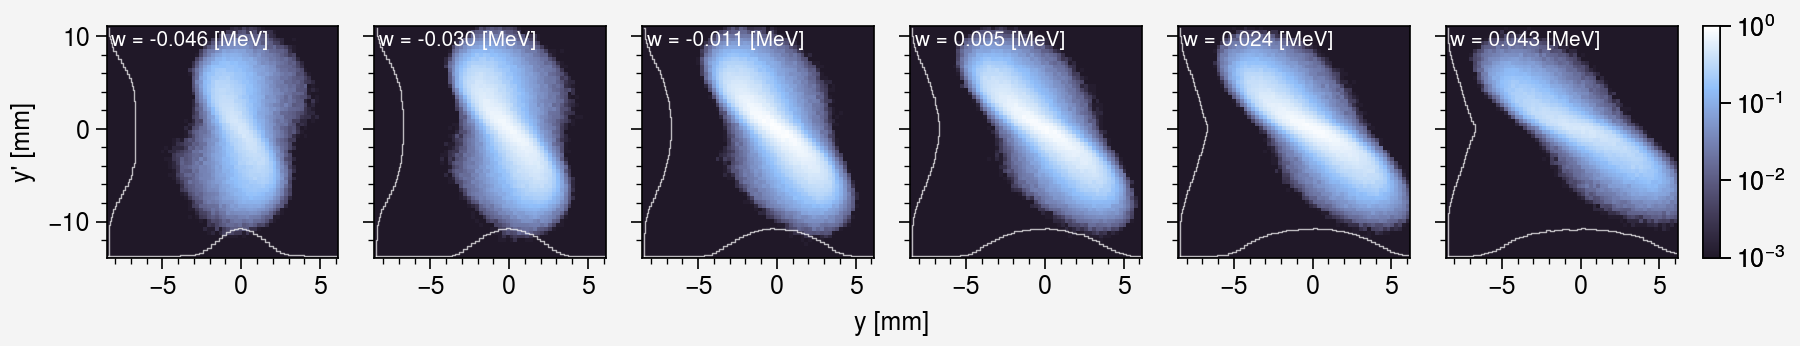

In [16]:
n = 6
ncols = 6
nrows = int(np.ceil(n / ncols))
pad = 0.3
offset_l = int(pad * len(coords[4]))
offset_r = int(pad * len(coords[4]))
ks = np.linspace(offset_l, len(coords[4]) - 1 - offset_r, n).astype(int)
for j in range(4):
    for i in range(j):
        if not ((i == 0 and j == 1) or (i == 2 and j == 3)):
            continue
        f3d, _ = np.histogramdd(X5d[:, [i, j, 4]], [edges[i], edges[j], edges[4]])
        f3d = f3d / np.max(f3d)
        for norm in [None, 'log']:
            for fix_vmax in [False, True]:
                if not fix_vmax and norm == 'log':
                    continue
                if fix_vmax:
                    vmax = np.max(f3d[:, :, ks])
                    vmin = np.min(f3d[:, :, ks])
                    colorbar = False
                    contour = False
                    prof = True
                else:
                    vmin = vmax = None
#                     colorbar = 't'
                    colorbar = False
                    contour = True
                    prof = False
                _vmin = vmin if not norm else None
                _vmax = vmax if not norm else None
                for cmap in ['viridis', 'dusk_r']:
                    fig, axes = pplt.subplots(ncols=ncols, nrows=nrows, figwidth=9.0)
                    for ax, k in zip(axes, ks):      
                        image = f3d[:, :, k]
                        mplt.plot_image(
                            image, x=coords[i], y=coords[j], ax=ax,
                            norm=norm,
                            linewidth=0, rasterized=True, ec='None',
    #                             vmin=_vmin, vmax=_vmax,
                            vmin=0.001, vmax=1.0,
                            colorbar=ax==axes[-1],
                            colorbar_kw=dict(width=0.085, space=1),                            
    #                             colorbar=colorbar, 
    #                             colorbar_kw=dict(width=0.07),
                            contour=contour,
                            profx=prof,
                            profy=prof,
                            prof_kws=prof_kws,
                            cmap=cmap,
                            handle_log='floor',
                            frac_thresh=10.0**-3.5,
                            contour_kws=dict(color='white', lw=0.3, alpha=0.3, values=[0.001, 0.001000001])
                        )
                        ax.annotate(f'w = {coords[4][k]:.3f} [MeV]', xy=(0.02, 0.98), verticalalignment='top',
                                    xycoords='axes fraction', fontsize='small', color='white')
                    axes.format(xlabel=labels[i], ylabel=labels[j])
                    for png in [False, True]:
                        figname = f'figures/energy_slice_proj_{dims[i]}-{dims[j]}_{cmap}_{norm}'
                        if png:
                            figname += '.png'
                        plt.savefig(figname)
                    plt.show()

All projections.

In [ ]:
mplt.interactive_proj2d(f, coords=coords, dims=dims, units=units)

This will save a lot of files.

In [ ]:
# for i in trange(5):
#     for j in trange(i):
#         H = utils.project(f, (j, i))
#         H = H / np.max(H)
#         for norm in [None, 'log']:
#             for prof in [True, False]:
#                 fig, ax = pplt.subplots()
#                 mplt.plot_image(H, x=coords[j], y=coords[i], ax=ax,
#                                 profx=prof, profy=prof, prof_kws=prof_kws, 
#                                 frac_thresh=frac_thresh,
#                                 norm=norm, handle_log='floor', colorbar=True)
#                 ax.format(xlabel=dims_units[j], ylabel=dims_units[i])
#                 plt.savefig(f"_output/proj_{dims[j]}-{dims[i]}_{norm}")
#                 plt.close()

2D projections in corner plot.

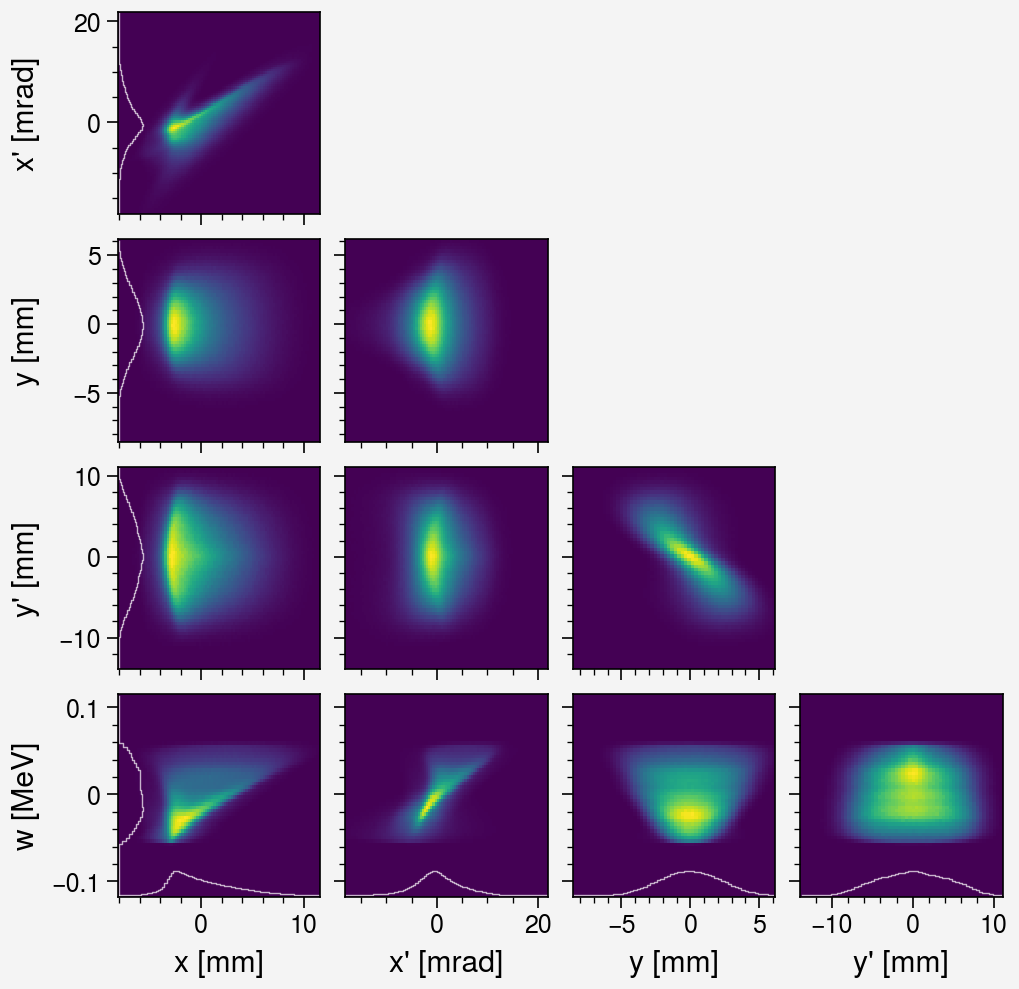

In [ ]:
for norm in [None, 'log'][:-1]:
    for cmap in ['viridis', 'dusk_r']:
        axes = mplt.corner(
            f,
            coords=coords,
            diag_kind='None',  # {'line', 'None'}
            prof='edges',
            prof_kws=prof_kws,
            fig_kws=dict(figwidth=(0.85 * 1.5 * 4), space=1),
            labels=["x [mm]", "x' [mrad]", "y [mm]", "y' [mm]", "w [MeV]"],
            norm=norm,
            handle_log='floor',
            frac_thresh=frac_thresh,
            linewidth=0, rasterized=True,
            discrete=False,
            cmap=cmap,
        )
        label_kw = dict(fontsize='large')
        axes.format(xlabel_kw=label_kw, ylabel_kw=label_kw)
        labels = ["x [mm]", "x' [mrad]", "y [mm]", "y' [mm]", "w [MeV]"]
        for ax, label in zip(axes[-1, :], labels):
            ax.format(xlabel=label)
        for ax, label in zip(axes[:, 0], labels[1:]):
            ax.format(ylabel=label)
        for png in [False, True]:
            figname = f'figures/int_corner_norm{norm}_{cmap}'
            if png:
                figname += '.png'
            plt.savefig(figname)
        plt.show()

In [ ]:
history = read_history(join(folder, hist_filename))
history

In [ ]:
fig, ax = pplt.subplots(figsize=(5.5, 2))
ax.plot(history['s'], history[['xrms', 'yrms']])
ax.format(ylabel='[mm]', xlabel='s [mm]')
ax.legend(ncols=1)
plt.savefig('figures/rms.png')
plt.show()

In [ ]:
fig, ax = pplt.subplots(figsize=(5.5, 2))
ax.plot(history['s'], history[['ex', 'ey']])
ax.format(ylabel='[mm mrad]', xlabel='s [mm]')
ax.legend(ncols=1)
plt.savefig('figures/emittance.png')
plt.show()